In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.8/dist-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [3]:
from mesh_tools import trimesh_utils as tu
from datasci_tools import ipyvolume_utils as ipvu
from neurd import neuron_visualizations as nviz
from pathlib import Path

In [4]:
segment_id = 864691135510518224

# Load the appropriate volume data inferface object

In [31]:
from neurd.vdi_microns import volume_data_interface as vdi
#vdi.set_parameters_for_directory_modules()

In [15]:
synapse_filepath = str(Path(f'./{segment_id}_synapses.csv').absolute())
synapse_filepath

'/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/864691135510518224_synapses.csv'

In [7]:
from datasci_tools import pandas_utils as pu
df = pu.csv_to_df(synapse_filepath)
df

,prepost,synapse_id,synapse_x,synapse_y,synapse_z,synapse_size,segment_id
0,presyn,483766883,1488728,621944,1110480,4384,864691135510518224
1,presyn,478550136,1485480,626880,1111240,2068,864691135510518224
2,presyn,480939462,1481320,565104,1111800,11064,864691135510518224
3,presyn,479220146,1482788,601920,1054840,8636,864691135510518224
4,presyn,468794187,1454888,618200,1093960,3516,864691135510518224
...,...,...,...,...,...,...,...
960,postsyn,483712349,1501720,609480,1075880,17880,864691135510518224
961,postsyn,492052366,1524840,622592,1056880,8680,864691135510518224
962,postsyn,486032429,1492720,571480,1029520,2244,864691135510518224
963,postsyn,477362400,1476856,585624,1113440,18312,864691135510518224


In [22]:
vdi.set_synapse_filepath(
    synapse_filepath
)

# Data Prep: Loading mesh

In [9]:
mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(154713, 3), faces.shape=(323535, 3), name=`864691135510518224.off`)>

In [10]:
from datasci_tools import pipeline

products = pipeline.PipelineProducts()
products

# Step 1: Decimation

In [ ]:
"""
NOTE: an already decimated mesh is used for the example
in order to speed up time, that's why the mesh_dec
object will be overwritten with original mesh object
"""

In [ ]:
decimation_parameters = dict(
    decimation_ratio =0.25,
)

In [ ]:
mesh_decimated = tu.decimate(
    mesh,
    **decimation_parameters
)

In [ ]:
# saving any parameters used or output products for later use
products.set_stage_attrs(
    stage = "decimation",
    attr_dict = dict(
        decimation_parameters = decimation_parameters,
        segment_id = segment_id,
    ),
    
)

print(products)

# Step 2: Soma Identification

In [ ]:
from neurd import soma_extraction_utils as sm
soma_extraction_parameters = dict()

In [ ]:
# could inspect the parameters of a certain category
from neurd import parameter_utils as paru
paru.category_param_from_module(
        module = sm,
        category = "glia",
)

In [ ]:
# overwritting decimated mesh because original was already decimated
mesh_decimated = mesh

# soma_indentification

In [ ]:
from neurd import neuron_visualizations as nviz

verbose = True

soma_products = sm.soma_indentification(
    mesh_decimated,
    verbose=verbose,
    **soma_extraction_parameters
)

In [ ]:
soma_products.soma_run_time

In [ ]:
sm.plot_soma_products(
    mesh_decimated,
    soma_products = soma_products,
    verbose = True
)

In [ ]:
products.set_stage_attrs(
    stage = "soma_identification",
    attr_dict = soma_products,
)

print(products)

# Step 2b: Saving off pipeline products

In [ ]:
from datasci_tools import system_utils as su
su.save_object(
    products,"products_up_to_soma_stage"
)

# Step 3: Decomposition

In [ ]:
from neurd import neuron

neuron_obj = neuron.Neuron(
    mesh = mesh,
    segment_id = segment_id, # don't need this explicitely if segment_id is already in products
    pipeline_products = products,
    suppress_preprocessing_print=False,
    suppress_output=False,
)

neuron_obj

In [ ]:
nviz.visualize_neuron(
    neuron_obj,
    limb_branch_dict="all"
)

In [ ]:
nviz.visualize_neuron_limbs(neuron_obj)

In [ ]:
nviz.visualize_neuron_specific_limb(neuron_obj,"L2")

In [ ]:
ipvu.plot_objects(neuron_obj[2][0].mesh)

# Calculate statistics

In [ ]:
_ = neuron_obj.calculate_decomposition_products(
    store_in_obj = True,
)

In [ ]:
print(neuron_obj.pipeline_products)

# Saving off neuron

In [ ]:
vdi.save_neuron_obj(
    neuron_obj,
    verbose = True
)

# Reloading the Neuron

In [ ]:
neuron_obj = vdi.load_neuron_obj(
    segment_id = segment_id,
    #mesh_decimated = mesh_decimated
)

In [ ]:
print(neuron_obj.pipeline_products)

# Step 4A: Multi Soma Split Suggestions

In [ ]:
from neurd import neuron_visualizations as nviz
nviz.plot_soma_limb_concept_network(
    neuron_obj
)

In [ ]:
multi_soma_split_parameters = dict()

In [ ]:
_ = neuron_obj.calculate_multi_soma_split_suggestions(
    plot = True,
    store_in_obj = True,
    **multi_soma_split_parameters
)


In [ ]:
neuron_obj.pipeline_products.multi_soma_split_suggestions.multi_soma_split_parameters = multi_soma_split_parameters

# Step 4B: Multi Soma Split Execution

In [ ]:
neuron_list = neuron_obj.multi_soma_split_execution(
    verbose = False,
)

In [ ]:
ipvu.plot_objects(
    meshes = [
        neuron_list[0].mesh_from_branches,
        neuron_list[1].mesh_from_branches,
    ],
    meshes_colors=["red","blue"]
)

In [ ]:
n1 = neuron_list[0]
print(n1.pipeline_products)

# Step 4b: Saving Split Neurons

In [ ]:
vdi.save_neuron_obj(
    n1,
    suffix = "_split_0",
)

# Step 4c: Decompressing Split Neuron

In [27]:
from neurd import neuron_utils as nru

neuron_obj_path = Path(f"./{segment_id}_split_0.pbz2")
neuron_obj_path.exists()

n1 = nru.decompress_neuron(
    filepath = neuron_obj_path,
    original_mesh = mesh, 
    suppress_output = False
)

Inside decompress neuron and decomposition_type = meshafterparty
Recieved trimesh as orignal mesh
Original mesh BEFORE using original_mesh_idx = <trimesh.Trimesh(vertices.shape=(154713, 3), faces.shape=(323535, 3), name=`864691135510518224.off`)>
Original mesh AFTER using original_mesh_idx = <trimesh.Trimesh(vertices.shape=(93084, 3), faces.shape=(183876, 3))>
Passed faces original mesh check
Number of vertices in mesh used for compression (93087) does not match the number of vertices in mesh passed to decompress_neuron function (93084)
using precomputed soma_volume_ratios
Working on limb 0


  0%|          | 0/10 [00:00<?, ?it/s]

  Working on branch 0
  Working on branch 1
  Working on branch 2
  Working on branch 3
  Working on branch 4
  Working on branch 5
  Working on branch 6
  Working on branch 7
  Working on branch 8
  Working on branch 9
Working on limb 1


  0%|          | 0/27 [00:00<?, ?it/s]

  Working on branch 0
  Working on branch 1
  Working on branch 2
  Working on branch 3
  Working on branch 4
  Working on branch 5
  Working on branch 6
  Working on branch 7
  Working on branch 8
  Working on branch 9
  Working on branch 10
  Working on branch 11
  Working on branch 12
  Working on branch 13
  Working on branch 14
  Working on branch 15
  Working on branch 16
  Working on branch 17
  Working on branch 18
  Working on branch 19
  Working on branch 20
  Working on branch 21
  Working on branch 22
  Working on branch 23
  Working on branch 24
  Working on branch 25
Viable Non soma touching mesh(0): <trimesh.Trimesh(vertices.shape=(3012, 3), faces.shape=(5404, 3))> was not a match
Viable Non soma touching mesh(1): <trimesh.Trimesh(vertices.shape=(113, 3), faces.shape=(176, 3))> was not a match
  Working on branch 26
Viable Non soma touching mesh(0): <trimesh.Trimesh(vertices.shape=(3012, 3), faces.shape=(5404, 3))> was not a match
Working on limb 2


  0%|          | 0/5 [00:00<?, ?it/s]

  Working on branch 0
  Working on branch 1
  Working on branch 2
  Working on branch 3
  Working on branch 4
Working on limb 3


  0%|          | 0/1 [00:00<?, ?it/s]

  Working on branch 0
Working on limb 4


  0%|          | 0/1 [00:00<?, ?it/s]

  Working on branch 0
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 0.0001468658447265625
total_edges = [['S0', 'L0'], ['S0', 'L1'], ['S0', 'L2'], ['S0', 'L3'], ['S0', 'L4']]
--- 2) Finished creating neuron connectivity graph: 7.772445678710938e-05
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.0835576057434082
Using precomputed volume ratio
--- 3b) Finished soma creation: 0.04620862007141113
--- 3) Finshed generating soma objects and adding them to concept graph: 3.7670135498046875e-05
--- 4a) Finshed generating curr_limb_meshes_face_idx: 0.1631612777709961
curr_limb_concept_networks= {0: [<datasci_tools.networkx_utils.GraphOrderedEdges object at 0x7f2c18a67130>]}
curr_limb_concept_networks= {0: [<datasci_tools.networkx_utils.GraphOrderedEdges object at 0x7f2c18a72820>]}
curr_limb_concept_networks= {0: [<datasci_tools.networkx_utils.GraphOrderedEdges object at 0x7f2c18d4fb2

# Step 5: Cell Typing

In [53]:
from neurd import neuron_pipeline_utils as npu

In [54]:
neuron_obj_axon = npu.cell_type_ax_dendr_stage(
    n1,
    mesh_decimated = mesh_decimated,
    plot_axon = False,
)


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 4


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 1


Number of segments: 4


Number of segments: 4


Number of segments: 3


Number of segments: 2


Number of segments: 5


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segme

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.4835927486419678
branches_touching_root = [13]
combining close nodes
combine_threshold = 1300
length of Graph = 7906
After combining close endpoints max(kept_branches_idx) = 85, len(kept_branches_idx) = 75
empty_indices % = 0.0
 conflict_indices % = 0.028463139120095123
Decomposing first pass: 4.343215465545654
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.867813110351562e-06
Total time for MAP sublimb processing 2.1457672119140625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.52587890625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.03506302833557129
sbv[0].reshape(-1,3) = [[1484150.   588282.7 1095391. ]]
closest_sk_pt_coord BEFORE = [1484209.07018222  588125.41800575 1095073.94391184]
current_

100%|██████████| 1/1 [00:00<00:00, 373.66it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.019484996795654297
branches_touching_root = [0]
combining close nodes
combine_threshold = 1300
length of Graph = 20
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
Decomposing first pass: 0.0211336612701416
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 8.106231689453125e-06
Total time for MAP sublimb processing 2.384185791015625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.5735626220703125e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.04149317741394043
Removed 0 skeletal branches
175 176
For marked faces: None
empty_indices % = 0.0
 c

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.0998678207397461
Floating 1: <trimesh.Trimesh(vertices.shape=(3012, 3), faces.shape=(5404, 3))>
invalidation_d = 1500
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 1150
filter_end_node_length_meshparty = 1150
invalidation_d = 1500
root_curr = None
Time for preparing soma vertices and root: 3.814697265625e-06
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 26.27it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.08027148246765137
branches_touching_root = [6]


combining close nodes
combine_threshold = 1300
length of Graph = 344
After combining close endpoints max(kept_branches_idx) = 12, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.0902269743012568
Decomposing first pass: 0.32084155082702637
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 2.2411346435546875e-05
Total time for MAP sublimb processing 3.337860107421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.0742416381835938e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.41527700424194336
Removed 2 skeletal branches
5403 5404
For marked faces: None
empty_indices % = 0.0007401924500370096
 conflict_indices % = 0.0


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 1.0048227310180664
The closest float distance was 23581.571737481798 which was greater than the maximum stitch distance 5000
 --> so ending the floating mesh stitch processs
concept_network_dict = {0: [<datasci_tools.networkx_utils.GraphOrderedEdges object at 0x7f2a4eaaf820>]}


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [1484351.   588129.9 1095200. ]---------
Starting_edge inside branches_to_conept = [[1467806.   619005.5 1081192. ]
 [1484351.   588129.9 1095200. ]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [59]
printing out current edge:
[[1484351.   588129.9 1095200. ]
 [1467806.   619005.5 1081192. ]]
edge_endpoints_to_process was empty so exiting loop after 76 iterations
starting_node in concept map (that should match the starting edge) = 53
Total time for branches to concept conversion = 0.48364853858947754

Done generating concept network 



Number of segmen

invalidation_d = 1500
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 1150
filter_end_node_length_meshparty = 1150
invalidation_d = 1500
root_curr = [ 552945.2  757231.5 1044509. ]
Time for preparing soma vertices and root: 0.0002758502960205078
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 1.4520647525787354
branches_touching_root = [16]
combining close nodes
combine_threshold = 1300
length of Graph = 13106
After combining close endpoints max(kept_branches_idx) = 230, len(kept_branches_idx) = 190
empty_indices % = 0.0
 conflict_indices % = 0.05154251788018087
Decomposing first pass: 11.920819997787476
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 8.344650268554688e-06
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.6702880859375e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.01077127456665039
sbv[0].reshape(-1,3) = [[ 552945.2  757231.5 1044509. ]]
closest_sk_pt_coord BEFORE = [ 552495.72569604  757785.38871569 1044811.89960749]
curre

In [55]:
nviz.plot_axon(
    neuron_obj_axon
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Autoproofreading Stage

About to do syn_density stats
syn_density_post = 0.8803287040287175
syn_density_head = 0.3698102137825556
syn_density_neck = 0.005411856787061789
syn_density_shaft = 0.3968694977178645
sk_length_synapse_density = 554338.3940188786
About to do spine_density stats
postsyn_limb_branch = {'L0': array([0, 1, 3, 4, 5, 9]), 'L2': array([3]), 'L3': array([0]), 'L4': array([0])}
sk_length = 525317.6092909338
# of spines = 257
Density = 0.48922784131850233
spine_density = 0.48922784131850233 (multiplier = 1000)
sk_length spine density = 525317.6092909338
Done stats
Not apply_hand_made_low_rules
For model: LogisticRegression(class_weight={'excitatory': 1, 'inhibitory': 1.5}) 
with features: ['syn_density_shaft', 'spine_density']
pred_class = excitatory, pred_class_label = excitatory
Total time for e/i calculations = 0.07331180572509766
baylor_e_i = excitatory

*****Using v7 Filters!!!


Current node skip distance was 1519.343930041573 but max skip distance was 1519.343930041573
Current node skip 

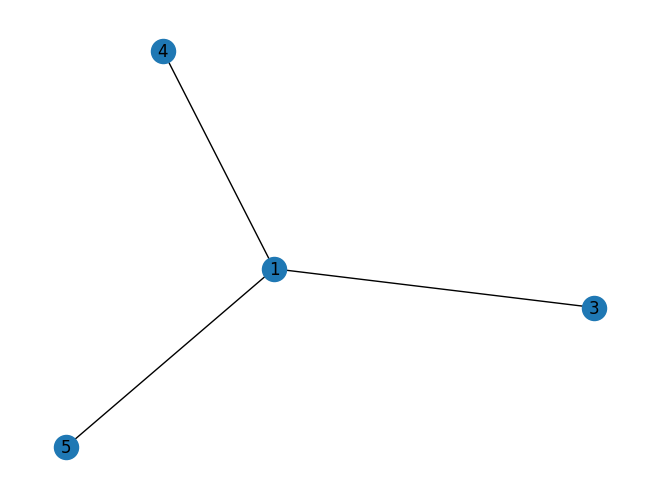

Performing global features query
Done with edge_df: 0.0006167888641357422
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   
1  1  4     51.52   30.123858               0.412657              0.000194   
2  1  5     38.18   27.008424               0.270062              0.000038   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                2                       None                          None  
2                1                       None                          None  
Afer Global query: 
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   


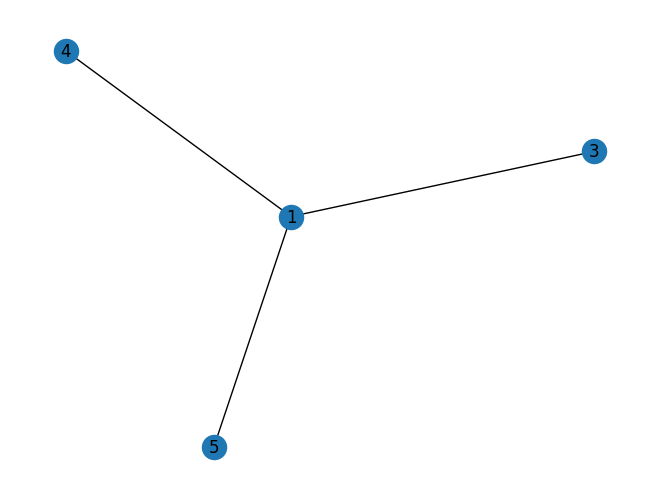

Performing node features query
Done with edge_df: 0.0006041526794433594
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   
1  1  4     51.52   30.123858               0.412657              0.000194   
2  1  5     38.18   27.008424               0.270062              0.000038   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                2                       None                          None   
2                1                       None                          None   

  above_threshold_delete  
0                   None  
1                   True  
2                   None  
Afer Node query: 
   u  v  sk_angle  width_diff  width_diff_percent

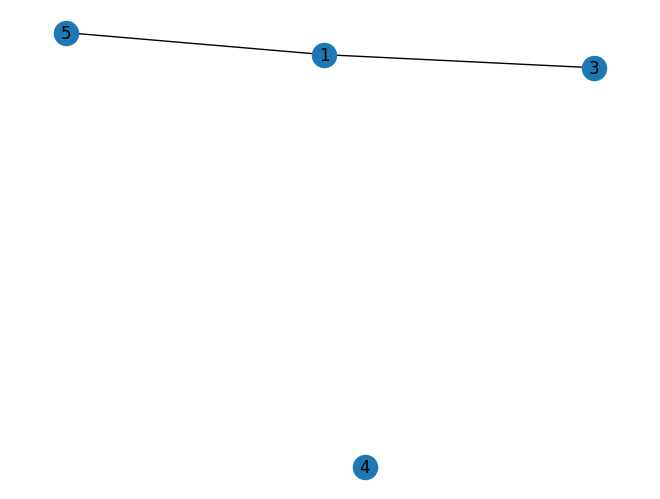

for upstream node 5, winning_node = None, error_branches = [1 3 4]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1438.048941983968 but max skip distance was 1438.048941983968
Current node skip distance was 1430.4806768165622 but max skip distance was 1430.4806768165622
Current node skip distance was 1395.1715386565604 but max skip distance was 1395.1715386565604
Current node skip distance was 1731.0070642096862 but max skip distance was 1731.0070642096862
Current node skip distance was 1463.5990860405466 but max skip distance was 1463.5990860405466
Current node skip distance was 1420.3625009675757 but max skip distance was 1923.9180300989
Current node skip distance was 1410.459385206235 but max skip distance was 1410.459385206235
Current node skip distance was 1396.4701283307018 but max skip distance was 1396.4701283307018
Current node skip distance was 1557.7705577183872 but max skip distance was 1648.8555220772

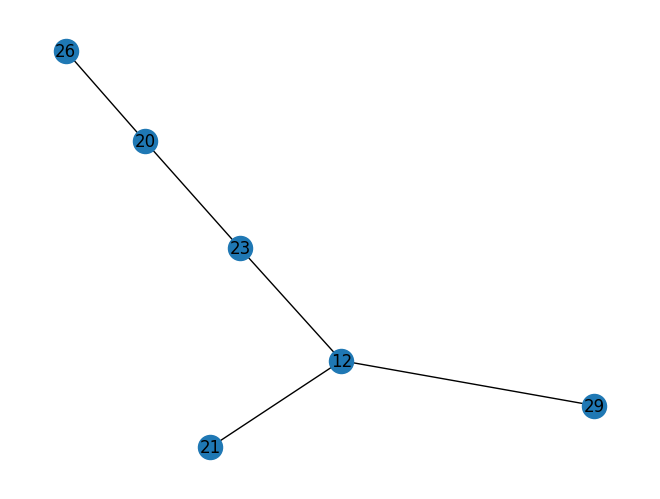

Performing global features query
Done with edge_df: 0.0009453296661376953
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  12  21     52.72   28.404077               0.466505                   0.0   
1  12  23     57.20    0.871714               0.014317                   0.0   
2  12  29     34.74   10.161649               0.166894                   0.0   
3  23  20     53.63   42.346084               0.406764                   0.0   
4  26  20     14.73    2.691328               0.025852                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3       

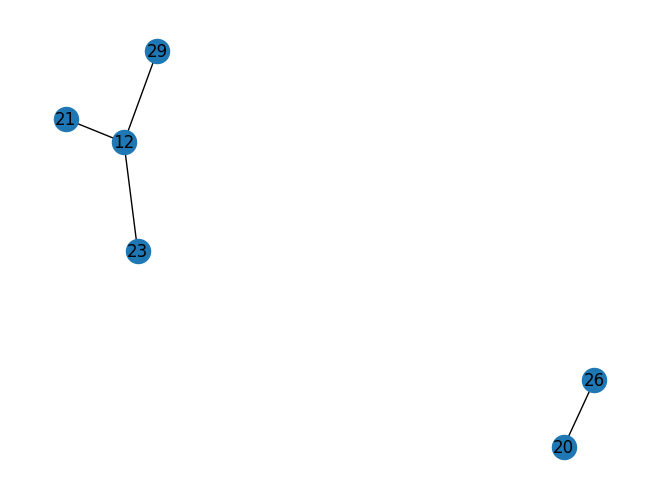

Performing node features query
Done with edge_df: 0.0006625652313232422
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  12  21     52.72   28.404077               0.466505                   0.0   
1  12  23     57.20    0.871714               0.014317                   0.0   
2  12  29     34.74   10.161649               0.166894                   0.0   
3  26  20     14.73    2.691328               0.025852                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3                0                      False                         False   

  above_

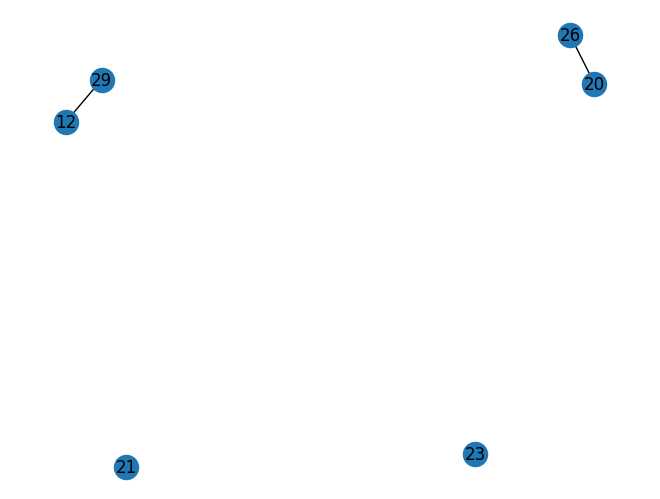

for upstream node 20, winning_node = 26, error_branches = [12 21 23 29]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1538.7128201302821 but max skip distance was 1538.7128201302821
Current node skip distance was 1489.1567938332191 but max skip distance was 1489.1567938332191
Current node skip distance was 1423.9946428663225 but max skip distance was 1423.9946428663225
Current node skip distance was 1843.055688371241 but max skip distance was 1870.3007499853125
Current node skip distance was 1870.3007499853125 but max skip distance was 1870.3007499853125
Current node skip distance was 1611.6505289229938 but max skip distance was 1611.6505289229938
Current node skip distance was 1551.6937888199488 but max skip distance was 1551.6937888199488
Current node skip distance was 1735.4778038110828 but max skip distance was 1843.055688371241
branch_match_query = :
(((width_diff < 75) or (width_diff_percentag

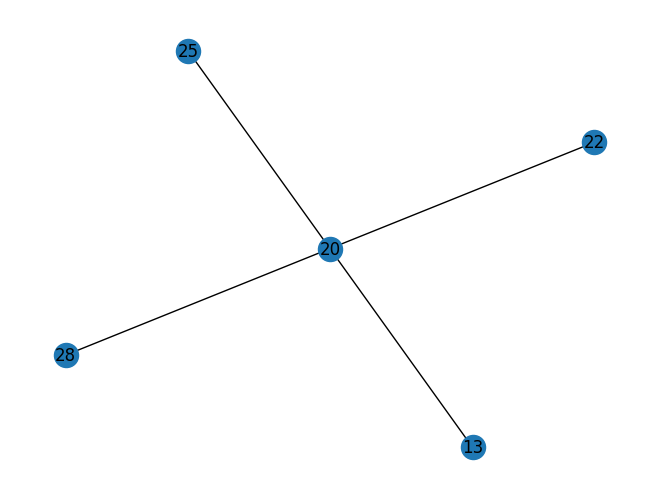

Performing global features query
Done with edge_df: 0.0008680820465087891
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  13  20     20.72   45.594546               0.779257                   0.0   
1  20  22     27.54   26.707168               0.256541                   0.0   
2  20  25     63.33   64.767381               0.622136                   0.0   
3  20  28     13.50   32.409874               0.237409                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3                0                       None                          None  
Afer Globa

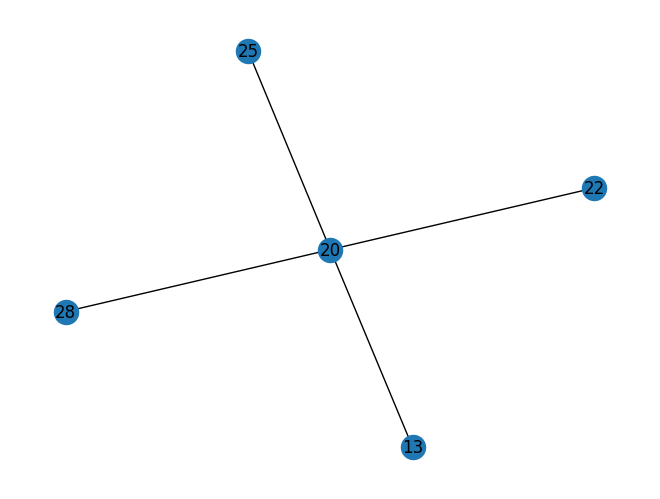

Performing node features query
Done with edge_df: 0.0008280277252197266
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  13  20     20.72   45.594546               0.779257                   0.0   
1  20  22     27.54   26.707168               0.256541                   0.0   
2  20  25     63.33   64.767381               0.622136                   0.0   
3  20  28     13.50   32.409874               0.237409                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3                0                       None                          None   

  above_

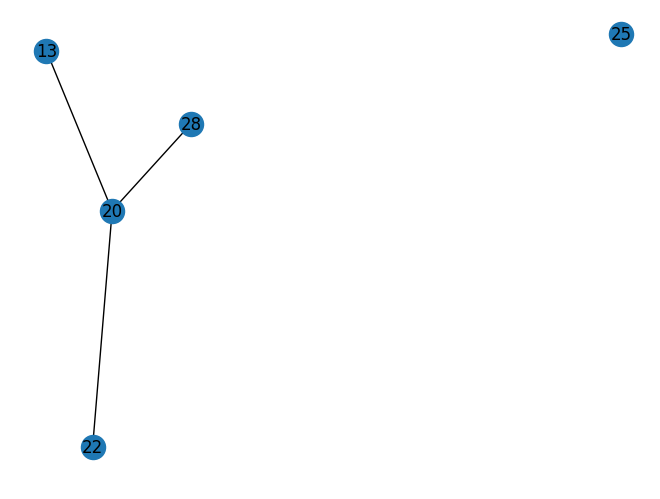

for upstream node 28, winning_node = None, error_branches = [13 20 22 25]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1462.702705562729 but max skip distance was 1462.702705562729
Current node skip distance was 1826.2385344561253 but max skip distance was 1826.2385344561253
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0010497570037841797
Performing Edge Query
After edge filter, # of rows = 3
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.576762               0.306972              0.000082   
1  10  28     47.78    1.072978               0.007922              0.000000   
2  10  30     91.23   22.855553               0.144384              0.000000   
3  16

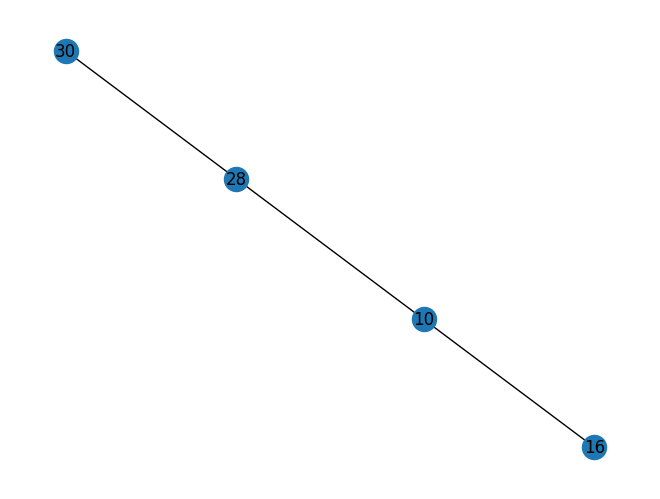

Performing global features query
Done with edge_df: 0.0008447170257568359
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.576762               0.306972              0.000082   
1  10  28     47.78    1.072978               0.007922              0.000000   
2  28  30     43.46   21.782575               0.137606              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                9                      False                          None  
1                0                       True                          None  
2                0                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.576762               0.306972              

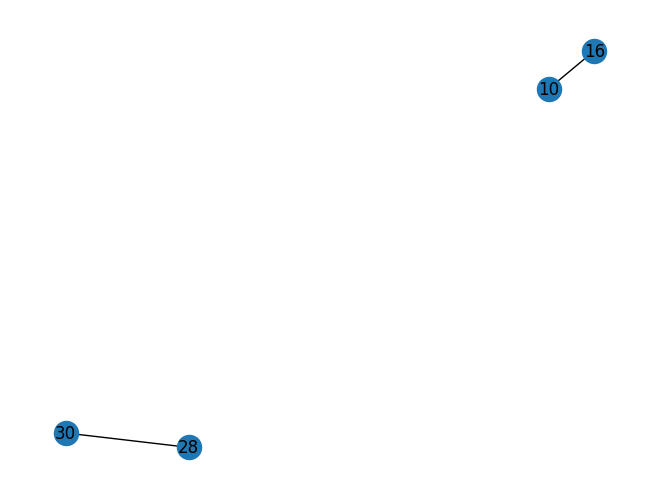

Performing node features query
Done with edge_df: 0.000591278076171875
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.576762               0.306972              0.000082   
1  28  30     43.46   21.782575               0.137606              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                9                      False                          None   
1                0                       None                          None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.576762               0.306972              0.000082   
1  28  30     43.46   21.782575               0.137606              

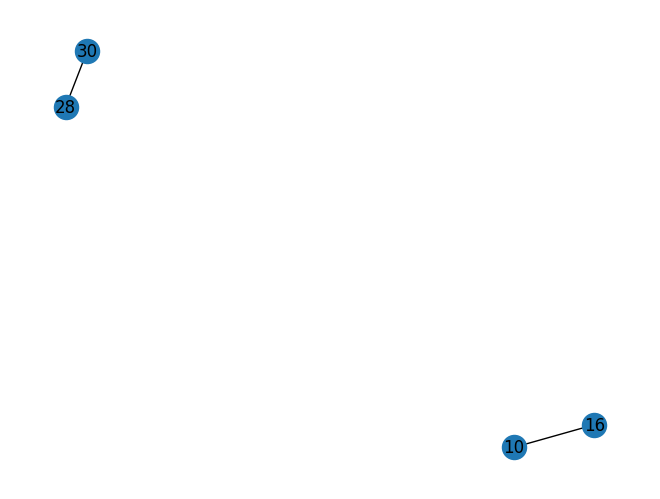

for upstream node 30, winning_node = 28, error_branches = [10 16]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (136.51467291466005) less than width_min(250)
Current node skip distance was 1502.8179992499754 but max skip distance was 1502.8179992499754
Current node skip distance was 1570.1121122556356 but max skip distance was 1570.1121122556356
Current node skip distance was 1608.7992850545759 but max skip distance was 1826.2385344561253
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0007352828979492188
Performing Edge Query
After edge filter, # of rows = 3
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  30     77.08   65.890739               0.713053                   0.0   
1  27  32     25.52    4.420398               

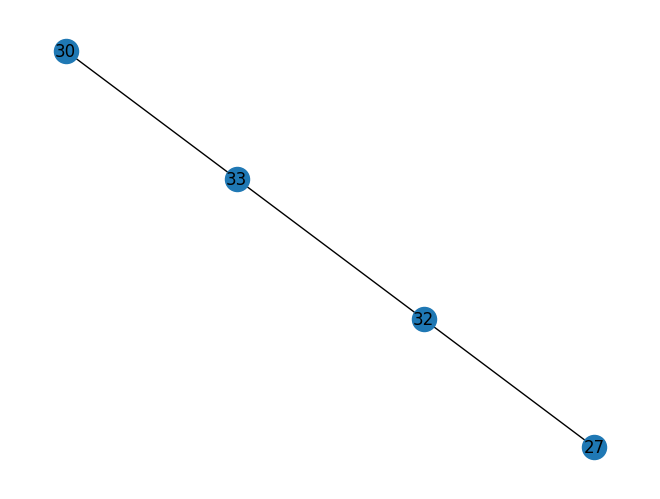

Performing global features query
Done with edge_df: 0.0006992816925048828
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52    4.420398               0.047836                   0.0   
1  30  33     47.52   52.185420               0.491796                   0.0   
2  32  33     12.61    9.284921               0.087501                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52    4.420398               0.047836              

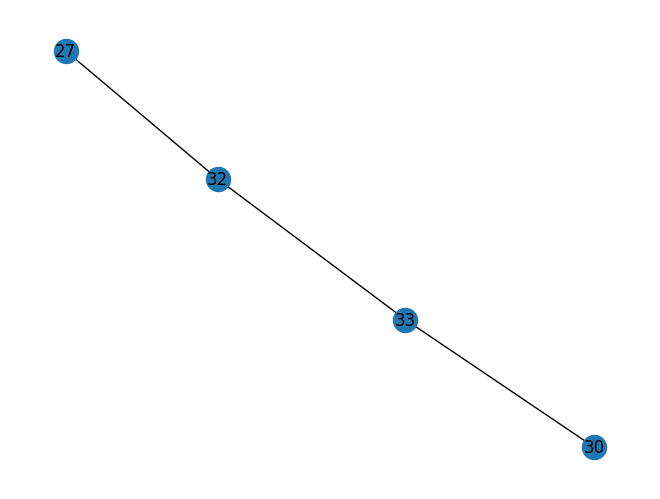

Performing node features query
Done with edge_df: 0.0009164810180664062
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52    4.420398               0.047836                   0.0   
1  30  33     47.52   52.185420               0.491796                   0.0   
2  32  33     12.61    9.284921               0.087501                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   

  above_threshold_delete  
0                   None  
1                   True  
2                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_di

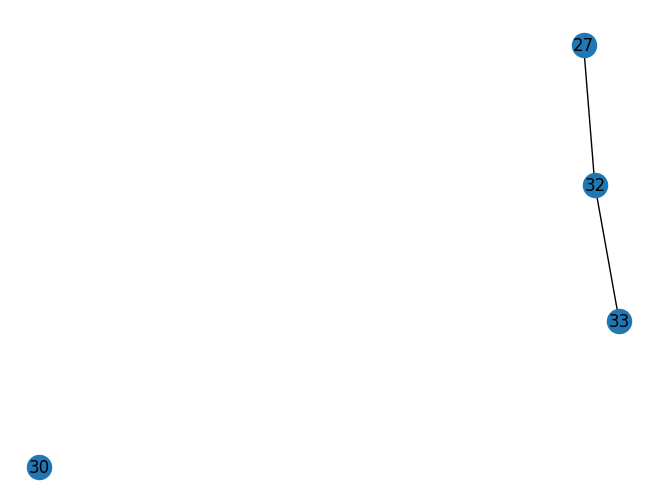

for upstream node 33, winning_node = None, error_branches = [27 30 32]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1750.896595902963 but max skip distance was 1750.896595902963
Current node skip distance was 1533.9125042809317 but max skip distance was 1533.9125042809317
Current node skip distance was 1645.6040467539192 but max skip distance was 1645.6040467539192
Current node skip distance was 1430.495890861237 but max skip distance was 1653.4592732338874
Current node skip distance was 1479.28828785825 but max skip distance was 1645.6040467539192
Current node skip distance was 1438.787336903817 but max skip distance was 1438.787336903817
Current node skip distance was 1794.205615964951 but max skip distance was 1794.205615964951
Current node skip distance was 1459.4197789215646 but max skip distance was 2141.3451010899726
Current node skip distance was 1903.2530417833777 but max skip distance was 1903.25304178

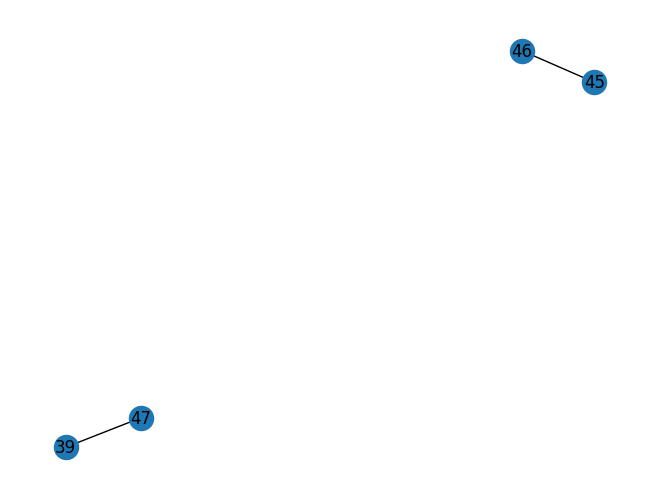

Performing global features query
Done with edge_df: 0.0005648136138916016
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   23.183247               0.115937                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_partner_width_delete  
0                0                       False                          False  
1                0                       False                          False  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   23.183247               0.115937                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_pa

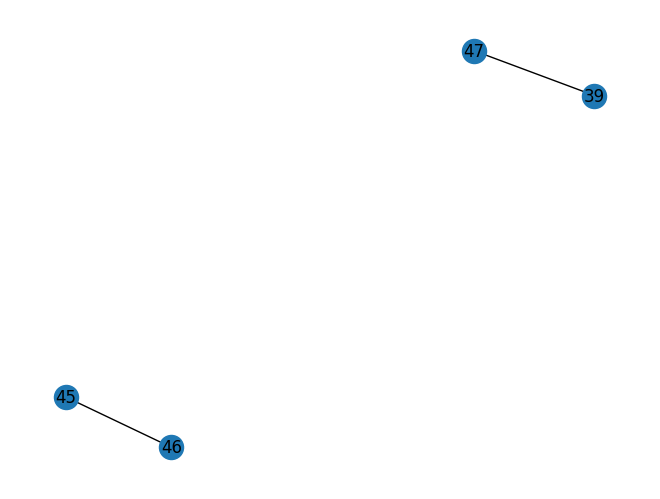

Performing node features query
Done with edge_df: 0.0006647109985351562
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   23.183247               0.115937                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_partner_width_delete  \
0                0                       False                          False   
1                0                       False                          False   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   23.183247               0.115937       

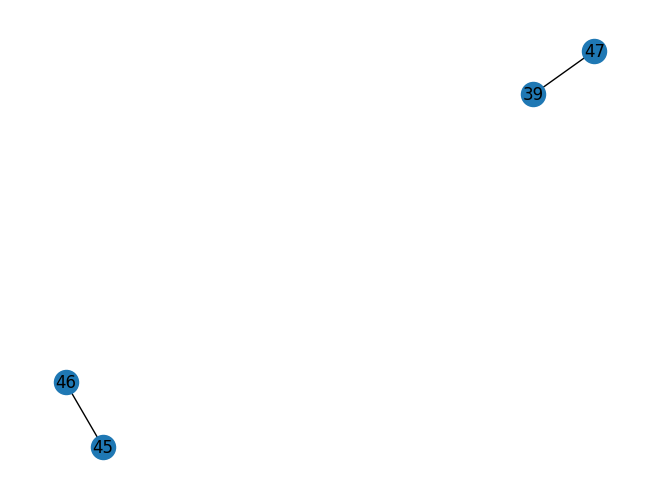

for upstream node 46, winning_node = 45, error_branches = [39 47]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (176.78073002801082) less than width_min(250)
Current node skip distance was 1506.165582874341 but max skip distance was 1506.165582874341
Current node skip distance was 1450.4508458210582 but max skip distance was 1450.4508458210582
Current node skip distance was 2028.8753734282018 but max skip distance was 2028.8753734282018
Current node skip distance was 1874.4952927129884 but max skip distance was 2028.8753734282018
Current node skip distance was 1915.3718706738891 but max skip distance was 2153.0164551047833
Current node skip distance was 1445.777336920075 but max skip distance was 1468.5371695391739
Current node skip distance was 1490.3557228824159 but max skip distance was 1490.3557228824159
Current node skip distance was 1386.5517768828443 but max skip distance was 1386.5517768828443
Current node skip distance was 1468.5371695391739 but max 

In [56]:
neuron_obj_proof = npu.auto_proof_stage(
    neuron_obj_axon,
    mesh_decimated = mesh_decimated,
    calculate_after_proof_stats = False,
)

In [57]:
_ = npu.after_auto_proof_stats(
    neuron_obj_proof,
    store_in_obj = True,
)

No skeletons to stack so returning empty list

Working on compartment basal---
Compartment limb stats = {'n_limbs': 4, 'soma_angle_max': 171.02, 'soma_angle_min': 20.41}

Working on compartment apical_total---
Compartment limb stats = {'n_limbs': 0, 'soma_angle_max': None, 'soma_angle_min': None}

Working on compartment axon---
Compartment limb stats = {'n_limbs': 1, 'soma_angle_max': 80.63, 'soma_angle_min': 80.63}

Working on compartment dendrite---
Compartment limb stats = {'n_limbs': 4, 'soma_angle_max': 171.02, 'soma_angle_min': 20.41}


# Saving off the autoproofread neuron

In [58]:
vdi.save_neuron_obj_auto_proof(
    neuron_obj_proof,
)

Total time for soma meshes compression = 0.28560376167297363
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.19256114959716797
Total time for limb_meshes compression = 0.26665687561035156
    Starting Limb Correspondence Compression
Total time for new_limb_correspondence compression = 0.839918851852417
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:139818929576016
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:139818950236672
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:139818929576352
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:139818929577408
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:139818950219664
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:139818950220816
Cleared mesh: <trimesh.Trimesh(ver

'864691135510518224_auto_proof.pbz2'

# Plotting the final neuron

In [59]:
from neurd import synapse_utils as syu

In [ ]:
from datasci_tools import ipyvolume_utils as ipvu
ipvu.plot_objects(
    neuron_obj_axon.mesh,
    meshes = [neuron_obj_proof.mesh],
    meshes_colors="red"
)

In [ ]:
syu.plot_synapses(neuron_obj_proof)

In [62]:
syu.plot_synapses_error_from_neuron_obj(neuron_obj_proof)    

# of error synapses = 408

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [63]:
syu.plot_synapses_valid_from_neuron_obj(neuron_obj_proof)  

# of valid synapses = 557

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [55]:
nviz.plot_compartments(neuron_obj_proof)

[autoreload of neurd.vdi_default failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 305, in update_function
    setattr(old, name, getattr(new, name))
ValueError: segment_id_to_synapse_table_optimized_proofread() requires a code


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

apical:blue
apical_shaft:aqua
apical_tuft:purple
basal:yellow
axon:red
oblique:green


Unlabeled: transparent green
